**1. PROBLEMA DE NEGÓCIO**

A MarketingAI é uma pequena cadeia de shopping centers localizada nos Estados Unidos, atualmente em processo de transformação digital. Como parte dessa modernização, a empresa decidiu incorporar inteligência artificial e análise avançada de dados em suas operações estratégicas. O principal desafio identificado pela organização está relacionado à baixa previsibilidade das vendas e à ausência de uma visão integrada do comportamento de demanda entre produtos, lojas, categorias e regiões.

O problema de negócio, portanto, é criar um modelo de previsão de vendas robusto e preciso, capaz de apoiar a estratégia operacional e comercial da empresa.


**2. ANÁLISE DOS DADOS**

In [ ]:
# 2. Conexões e Análise de Dados

import pandas as pd
df=pd.read_csv('data/raw/base_mensal.csv')
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951360 entries, 0 to 1951359
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   year_month  object 
 1   id          object 
 2   item        object 
 3   category    object 
 4   department  object 
 5   store       object 
 6   store_code  object 
 7   region      object 
 8   sales       int64  
 9   mean_price  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 148.9+ MB


In [ ]:
# Exibir as primeiras linhas do DataFrame
df.head()


,year_month,id,item,category,department,store,store_code,region,sales,mean_price
0,2011-01,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,NaN
1,2011-01,ACCESORIES_1_001_BOS_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Roxbury,BOS_2,Boston,0,NaN
2,2011-01,ACCESORIES_1_001_BOS_3,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Back_Bay,BOS_3,Boston,0,NaN
3,2011-01,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,NaN
4,2011-01,ACCESORIES_1_001_NYC_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Harlem,NYC_2,New York,0,NaN


In [ ]:
# Exibir as últimas linhas do DataFrame
df.tail()

,year_month,id,item,category,department,store,store_code,region,sales,mean_price
1951355,2016-04,SUPERMARKET_3_827_NYC_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,133,1.2
1951356,2016-04,SUPERMARKET_3_827_NYC_4,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Brooklyn,NYC_4,New York,38,1.2
1951357,2016-04,SUPERMARKET_3_827_PHI_1,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Midtown_Village,PHI_1,Philadelphia,75,1.2
1951358,2016-04,SUPERMARKET_3_827_PHI_2,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Yorktown,PHI_2,Philadelphia,66,1.2
1951359,2016-04,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,15,1.2


*year_month: Período (AAAA-MM) – manter como datetime/Period

*id: Identificador único da linha – descartar linha

*item: Produto – categórico, converter para string

*category: Categoria do produto – categórico, converter para string

*department: Departamento – categórico, converter para string

*store: Nome da loja - redundante com store_code, descartar linha

*store_code: Código da loja – converter para string (mesmo que seja numérico)

*region: Região – categórico, converter para string

*sales: Valor de vendas (alvo) – numérico (float) – verificar negativos (corrigir/filtrar), outliers e zeros  – nulos

*mean_price: Preço médio – numérico (float) – verificar negativos/zeros – nulos: imputar mediana por (item, mês)

In [ ]:
# Check missing values
df.isnull().sum()

,0
year_month,0
id,0
item,0
category,0
department,0
store,0
store_code,0
region,0
sales,0
mean_price,414540


In [ ]:
contagem_zeros = (df == 0).sum()
contagem_zeros


,0
year_month,0
id,0
item,0
category,0
department,0
store,0
store_code,0
region,0
sales,589041
mean_price,0


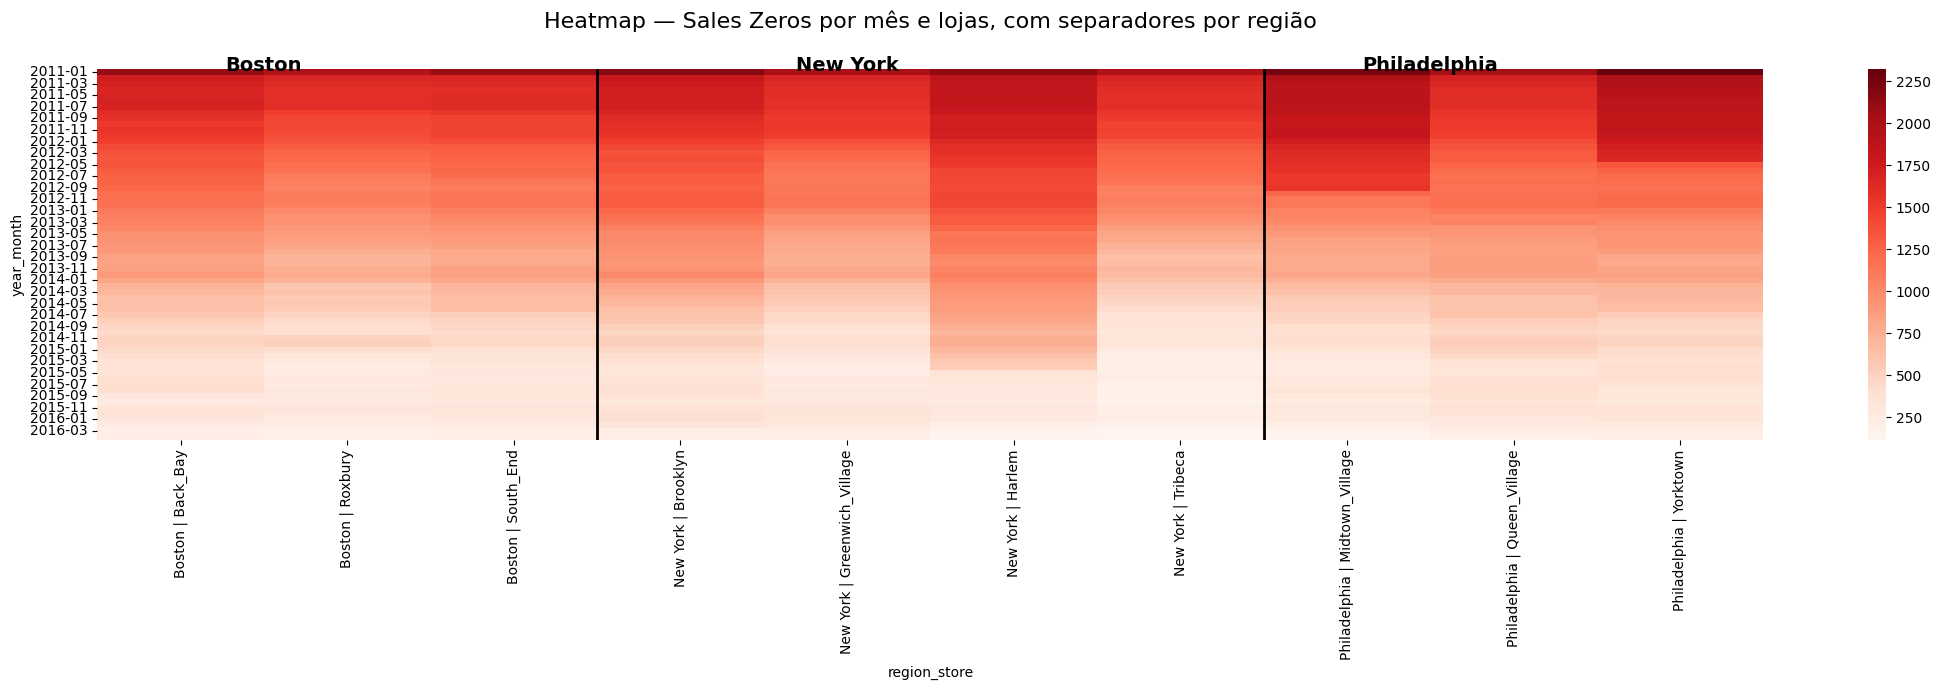

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define df_zero_sales by filtering for sales == 0
df_zero_sales = df[df['sales'] == 0].copy()

# Garantir formato mensal (sem horário!)
df_zero_sales["year_month"] = (pd.to_datetime(df_zero_sales["year_month"])
    .dt.to_period("M")
    .astype(str))  # <-- removendo horário e mantendo apenas YYYY-MM)

# Criar coluna Região + Loja
df_zero_sales["region_store"] = df_zero_sales["region"] + " | " + df_zero_sales["store"]

# Ordenar por região e loja
df_zero_sales = df_zero_sales.sort_values(["region", "store"])

# Pivot
tabela = df_zero_sales.pivot_table(index="year_month", columns="region_store",
    values="sales", aggfunc="count", fill_value=0)

# Colunas
cols = tabela.columns.tolist()
regions = [c.split(" | ")[0] for c in cols]

# Onde a região muda
change_indices = []
region_positions = {}

current_region = regions[0]
start_idx = 0

for i in range(1, len(regions)):
    if regions[i] != current_region:
        change_indices.append(i)
        region_positions[current_region] = (start_idx, i - 1)
        current_region = regions[i]
        start_idx = i

region_positions[current_region] = (start_idx, len(regions) - 1)

# Plot
plt.figure(figsize=(22,7))
ax = sns.heatmap(tabela, cmap="Reds")
plt.xticks(rotation=90)

# ✔ Título afastado dos nomes das regiões
plt.title("Heatmap — Sales Zeros por mês e lojas, com separadores por região",
          pad=30, fontsize=16)

# ✔ Separadores verticais
for idx in change_indices:
    plt.axvline(idx, color="black", linewidth=2)

# ✔ Nome das regiões acima dos blocos
y_pos = -0.7  # afastado dos labels do eixo X

for region, (start, end) in region_positions.items():
    mid = (start + end) / 2
    ax.text(mid, y_pos, region, ha='center', va='center',
            fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

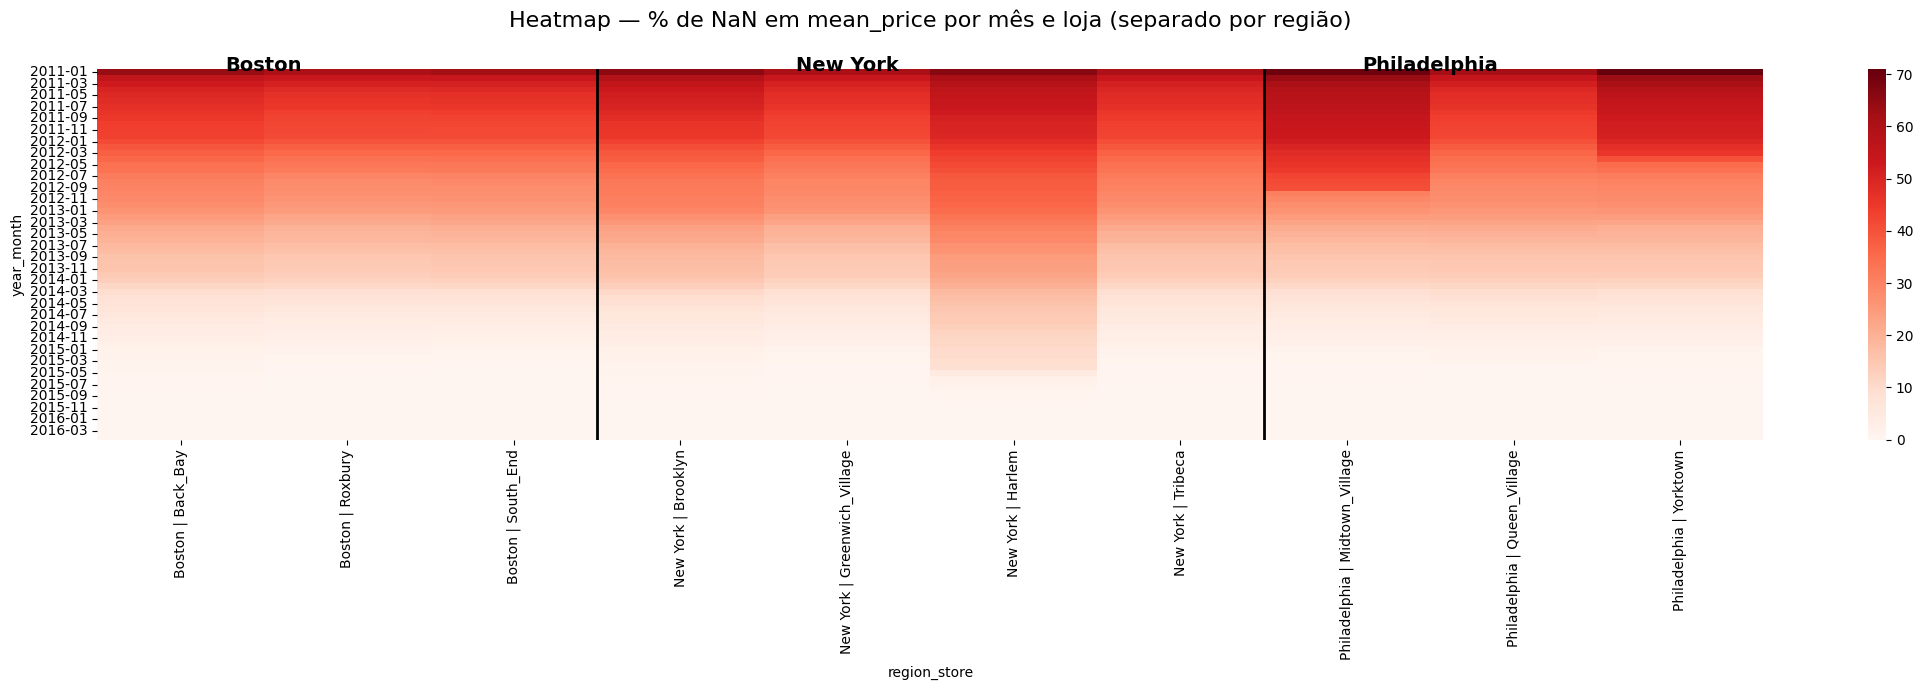

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Converter corretamente
df["mean_price"] = pd.to_numeric(df["mean_price"], errors="coerce")
df["year_month"] = pd.to_datetime(df["year_month"]).dt.to_period("M").astype(str)

# Criar coluna região + loja
df["region_store"] = df["region"] + " | " + df["store"]

# Criar tabela com TOTAL de registros por mês e loja
totais = df.pivot_table(index="year_month",
    columns="region_store",
    values="mean_price",
    aggfunc="size",
    fill_value=0)

# Criar tabela com QUANTIDADE de NaN por mês e loja
qtd_nan = df.pivot_table(index="year_month",
    columns="region_store",
    values="mean_price",
    aggfunc=lambda x: x.isna().sum(),
    fill_value=0)

# Percentual de NaN por célula
percent_nan = (qtd_nan / totais) * 100


# -------- IDENTIFICAR REGIÕES PARA SEPARADORES -------- #

cols = percent_nan.columns.tolist()
regions = [c.split(" | ")[0] for c in cols]

change_indices = []
region_positions = {}

current_region = regions[0]
start_idx = 0

for i in range(1, len(regions)):
    if regions[i] != current_region:
        change_indices.append(i)
        region_positions[current_region] = (start_idx, i - 1)
        current_region = regions[i]
        start_idx = i

region_positions[current_region] = (start_idx, len(regions) - 1)


# -------- PLOT -------- #

plt.figure(figsize=(22,7))
ax = sns.heatmap(percent_nan, cmap="Reds")
plt.xticks(rotation=90)

plt.title("Heatmap — % de NaN em mean_price por mês e loja (separado por região)",
          pad=30, fontsize=16)

# Traços
for idx in change_indices:
    plt.axvline(idx, color="black", linewidth=2)

# Nome das regiões
y_pos = -0.7
for region, (start, end) in region_positions.items():
    mid = (start + end) / 2
    ax.text(mid, y_pos, region, ha='center', va='center',
            fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


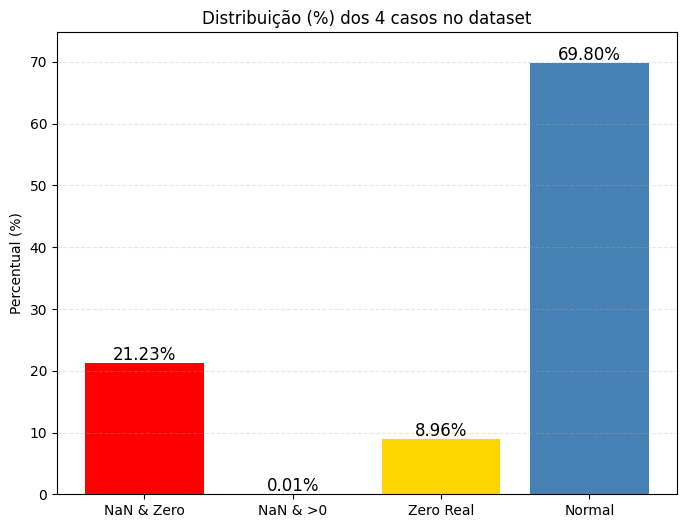

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure mean_price is numeric (re-applying from B0Nunjv0Ne_i for robustness)
df["mean_price"] = pd.to_numeric(df["mean_price"], errors="coerce")

total = len(df)

# Caso 1: mean_price NaN e sales == 0
case1 = df[(df["mean_price"].isna()) & (df["sales"] == 0)]
pct1 = (len(case1) / total) * 100

# Caso 2: mean_price NaN e sales > 0
case2 = df[(df["mean_price"].isna()) & (df["sales"] > 0)]
pct2 = (len(case2) / total) * 100

# Caso 3: sales == 0 e mean_price > 0
case3 = df[(df["sales"] == 0) & (df["mean_price"] > 0)]
pct3 = (len(case3) / total) * 100

# Caso normal
case_normal = total - (len(case1) + len(case2) + len(case3))
pct_normal = (case_normal / total) * 100

labels = ["NaN & Zero", "NaN & >0", "Zero Real", "Normal"]

values = [pct1,pct2,pct3,pct_normal]

plt.figure(figsize=(8,6))
bars = plt.bar(labels, values, color=["red", "orange", "gold", "steelblue"])
plt.ylabel("Percentual (%)")
plt.title("Distribuição (%) dos 4 casos no dataset")

# Mostrar o valor em cima da barra
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2,val + 0.5,f"{val:.2f}%",
        ha="center",
        fontsize=12)

plt.ylim(0, max(values) + 5)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()

**Legenda dos quatro casos analisados:**

NaN & Zero
Registros em que mean_price está ausente (NaN) e as vendas (sales) são igual a zero.
Representam, principalmente, zeros operacionais (falhas de registro de preço).

NaN & >0
Casos em que mean_price está ausente, mas houve venda.
São inconsistências raras, pois é improvável vender um item sem preço registrado.

Zero Real
Casos em que sales == 0 e mean_price > 0.
Representam baixa demanda real — situações em que o produto estava disponível, mas não houve venda.

Normal
Registros com preço válido e vendas válidas (> 0).
São a grande maioria do dataset e representam comportamento operacional adequado.

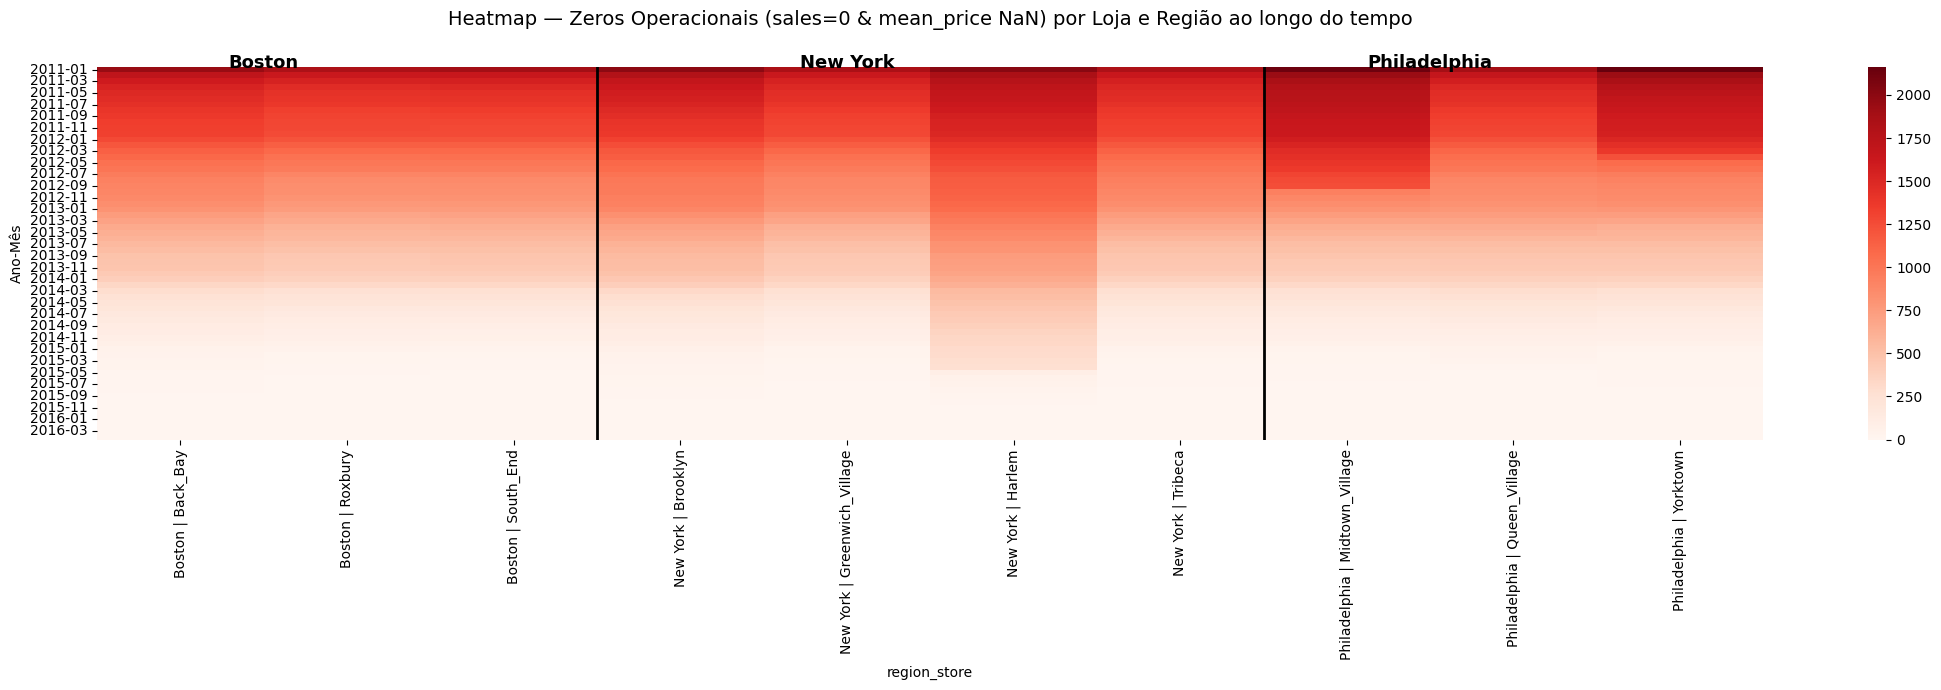

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Garantir tipos corretos
df["year_month"] = pd.to_datetime(df["year_month"]).dt.to_period("M").astype(str)
df["mean_price"] = pd.to_numeric(df["mean_price"], errors="coerce")

# 2) Zeros operacionais: sales == 0 e mean_price NaN
df["zero_operacional"] = ((df["sales"] == 0) & (df["mean_price"].isna())).astype(int)

# 3) Coluna Região + Loja
df["region_store"] = df["region"] + " | " + df["store"]

# 4) Ordenar por região e loja (isso organiza as colunas no heatmap)
df_ord = df.sort_values(["region", "store", "year_month"])

# 5) Pivot: linhas = meses, colunas = região+loja, valores = contagem de zeros operacionais
tabela = df_ord.pivot_table(index="year_month",columns="region_store",
    values="zero_operacional",
    aggfunc="sum",
    fill_value=0)

# 6) Descobrir onde cada região começa/termina nas colunas
cols = tabela.columns.tolist()
regions = [c.split(" | ")[0] for c in cols]

change_indices = []
region_positions = {}
current_region = regions[0]
start_idx = 0

for i in range(1, len(regions)):
    if regions[i] != current_region:
        change_indices.append(i)
        region_positions[current_region] = (start_idx, i - 1)
        current_region = regions[i]
        start_idx = i

# último bloco
region_positions[current_region] = (start_idx, len(regions) - 1)

# 7) Plot do heatmap
plt.figure(figsize=(22,7))
ax = sns.heatmap(tabela, cmap="Reds")
plt.xticks(rotation=90)

plt.title("Heatmap — Zeros Operacionais (sales=0 & mean_price NaN) por Loja e Região ao longo do tempo",
          pad=30, fontsize=14)
plt.ylabel("Ano-Mês")

# linhas verticais separando regiões
for idx in change_indices:
    plt.axvline(idx, color="black", linewidth=2)

# nomes das regiões acima dos blocos
y_pos = -0.7
for region, (start, end) in region_positions.items():
    mid = (start + end) / 2
    ax.text(mid, y_pos, region, ha='center', va='center',
            fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()


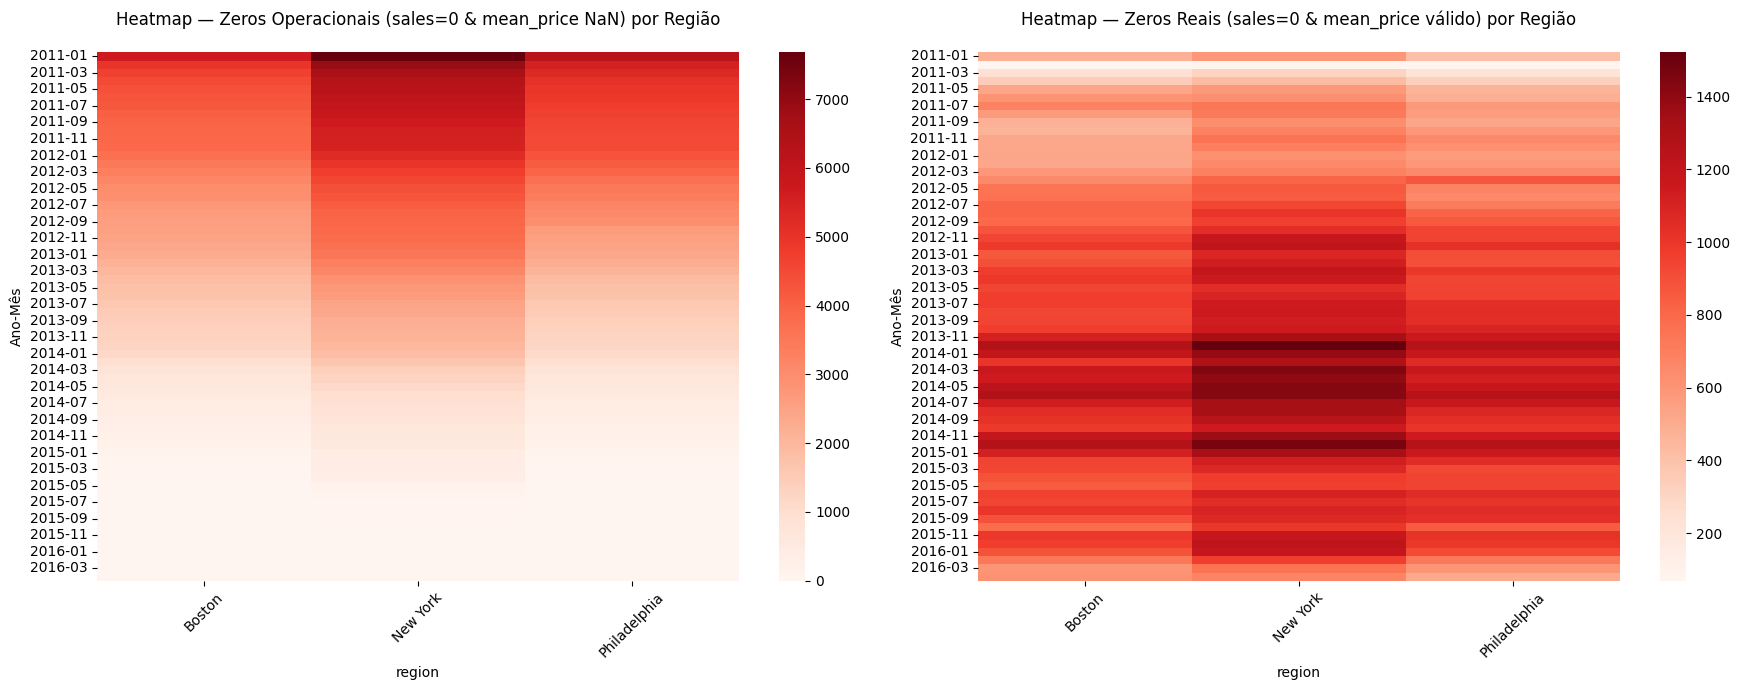

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Garantir formatos
df["year_month"] = pd.to_datetime(df["year_month"]).dt.to_period("M").astype(str)
df["mean_price"] = pd.to_numeric(df["mean_price"], errors="coerce")

# Classificação dos zeros
df["zero_operacional"] = ((df["sales"] == 0) & (df["mean_price"].isna())).astype(int)
df["zero_real"]        = ((df["sales"] == 0) & (~df["mean_price"].isna())).astype(int)

# Pivot para heatmap operacional
pivot_oper = df.pivot_table(index="year_month",columns="region",values="zero_operacional",aggfunc="sum",fill_value=0)

# Pivot para heatmap real
pivot_real = df.pivot_table(
    index="year_month",
    columns="region",
    values="zero_real",
    aggfunc="sum",
    fill_value=0)

# Plot lado a lado
plt.figure(figsize=(18,7))

# Heatmap Zeros Operacionais
plt.subplot(1,2,1)
sns.heatmap(pivot_oper, cmap="Reds")
plt.title("Heatmap — Zeros Operacionais (sales=0 & mean_price NaN) por Região", pad=20)
plt.xticks(rotation=45)
plt.ylabel("Ano-Mês")

# Heatmap Zeros Reais
plt.subplot(1,2,2)
sns.heatmap(pivot_real, cmap="Reds")
plt.title("Heatmap — Zeros Reais (sales=0 & mean_price válido) por Região", pad=20)
plt.xticks(rotation=45)
plt.ylabel("Ano-Mês")

plt.tight_layout()
plt.show()


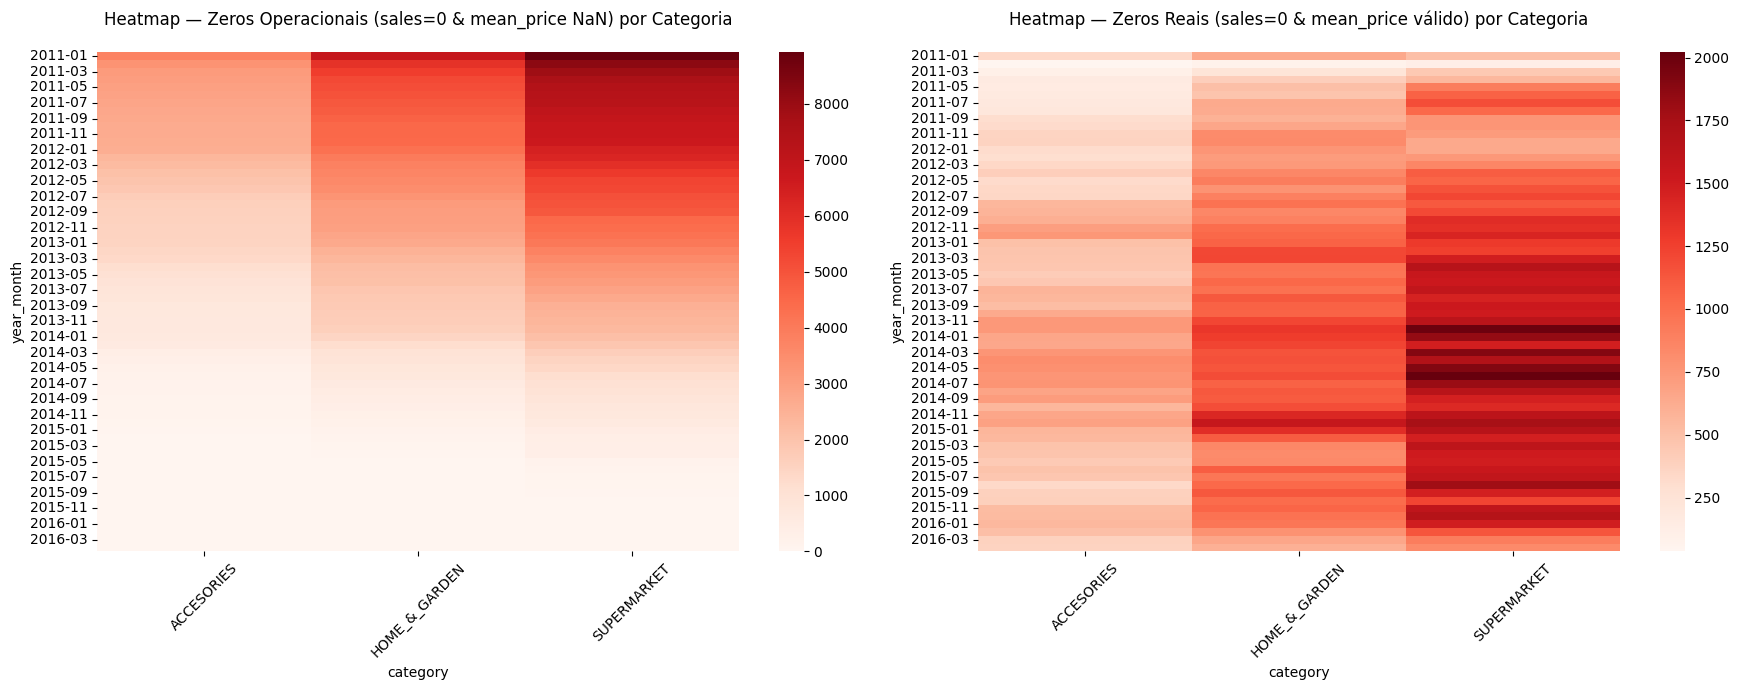

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Garantir formato ano-mês (sem horário)
df["year_month"] = pd.to_datetime(df["year_month"]).dt.to_period("M").astype(str)

# Garantir mean_price numérico
df["mean_price"] = pd.to_numeric(df["mean_price"], errors="coerce")

# Criar classificações
df["zero_operacional"] = ((df["sales"] == 0) & (df["mean_price"].isna())).astype(int)
df["zero_real"]        = ((df["sales"] == 0) & (~df["mean_price"].isna())).astype(int)

# Pivot para cada heatmap
pivot_oper = df.pivot_table(
    index="year_month",
    columns="category",
    values="zero_operacional",
    aggfunc="sum",
    fill_value=0)

pivot_real = df.pivot_table(
    index="year_month",
    columns="category",
    values="zero_real",
    aggfunc="sum",
    fill_value=0)

# Plot lado a lado
plt.figure(figsize=(18,7))

# Heatmap 1 — Zeros Operacionais
plt.subplot(1,2,1)
sns.heatmap(pivot_oper, cmap="Reds")
plt.title("Heatmap — Zeros Operacionais (sales=0 & mean_price NaN) por Categoria", pad=20)
plt.xticks(rotation=45)

# Heatmap 2 — Zeros Reais
plt.subplot(1,2,2)
sns.heatmap(pivot_real, cmap="Reds")
plt.title("Heatmap — Zeros Reais (sales=0 & mean_price válido) por Categoria", pad=20)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


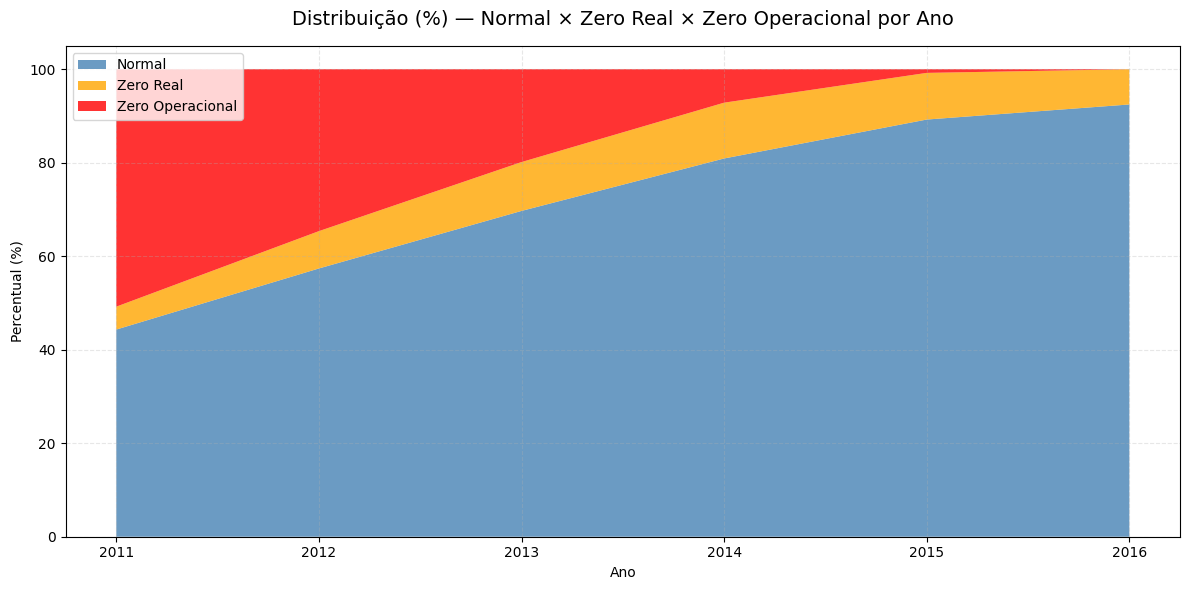

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Import numpy for pd.isna

# Reload df to ensure original mean_price NaNs are present for classification
df = pd.read_csv('/content/base_mensal.csv')

# Ensure mean_price numérico
df["mean_price"] = pd.to_numeric(df["mean_price"], errors="coerce")

# Criar ano
df["year_month"] = pd.to_datetime(df["year_month"]).dt.to_period("M").astype(str)
df["year"] = df["year_month"].str[:4]

# Classificar tipos de registros
df["zero_type"] = "normal"
df.loc[(df["sales"] == 0) & (df["mean_price"].isna()), "zero_type"] = "zero_operacional"
df.loc[(df["sales"] == 0) & (~df["mean_price"].isna()), "zero_type"] = "zero_real"

# Contagem por ano
resumo = df.groupby(["year", "zero_type"]).size().unstack(fill_value=0)

# Garantir colunas na ordem certa
# Check if 'zero_real' and 'zero_operacional' columns exist before reordering
columns_order = [col for col in ["normal", "zero_real", "zero_operacional"] if col in resumo.columns]
resumo = resumo[columns_order]

# Converter para percentual
percentual = resumo.div(resumo.sum(axis=1), axis=0) * 100

# Plot stacked area
plt.figure(figsize=(12,6))

plt.stackplot(
    percentual.index,
    percentual["normal"],
    percentual["zero_real"],
    percentual["zero_operacional"],
    labels=["Normal", "Zero Real", "Zero Operacional"],
    colors=["steelblue", "orange", "red"],
    alpha=0.8
)

plt.title("Distribuição (%) — Normal × Zero Real × Zero Operacional por Ano", fontsize=14, pad=15)
plt.xlabel("Ano")
plt.ylabel("Percentual (%)")
plt.legend(loc="upper left")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Garantir formatos
df["year_month"] = pd.to_datetime(df["year_month"]).dt.to_period("M").astype(str)
df["year"] = df["year_month"].str[:4]
df["mean_price"] = pd.to_numeric(df["mean_price"], errors="coerce")

# Classificações
df["zero_operacional"] = ((df["sales"] == 0) & (df["mean_price"].isna())).astype(int)
df["zero_real"]        = ((df["sales"] == 0) & (~df["mean_price"].isna())).astype(int)


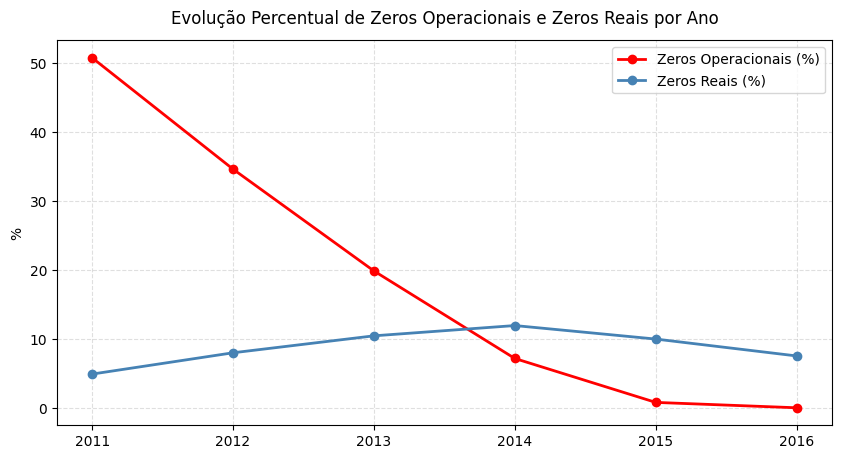

In [ ]:
total_por_ano = df.groupby("year").size()
zeros_por_ano = df.groupby("year")[["zero_operacional","zero_real"]].sum()

zeros_pct = (zeros_por_ano.div(total_por_ano, axis=0) * 100).round(2)

plt.figure(figsize=(10,5))
plt.plot(zeros_pct.index, zeros_pct["zero_operacional"], marker="o", linewidth=2, color="red", label="Zeros Operacionais (%)")
plt.plot(zeros_pct.index, zeros_pct["zero_real"], marker="o", linewidth=2, color="steelblue", label="Zeros Reais (%)")

plt.title("Evolução Percentual de Zeros Operacionais e Zeros Reais por Ano", pad=12)
plt.ylabel("%")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.show()


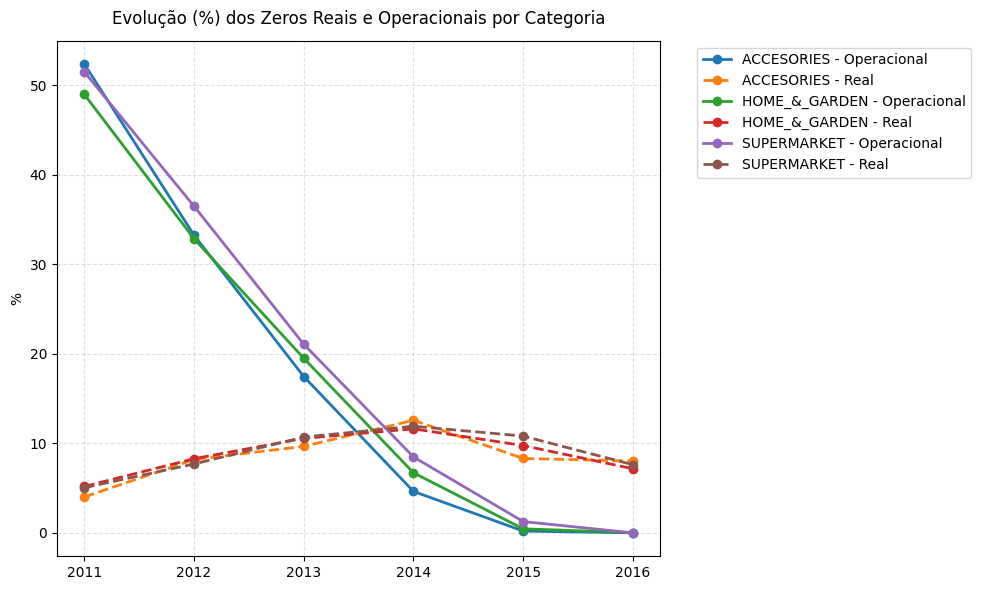

In [ ]:
plt.figure(figsize=(10,6))

for cat in df["category"].unique():
    subset = df[df["category"] == cat]

    total_year = subset.groupby("year").size()
    zeros_year = subset.groupby("year")[["zero_operacional","zero_real"]].sum()

    pct = (zeros_year.div(total_year, axis=0) * 100).round(2)

    plt.plot(pct.index, pct["zero_operacional"], marker="o", linewidth=2, label=f"{cat} - Operacional")
    plt.plot(pct.index, pct["zero_real"], marker="o", linewidth=2, linestyle="--", label=f"{cat} - Real")

plt.title("Evolução (%) dos Zeros Reais e Operacionais por Categoria", pad=12)
plt.ylabel("%")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


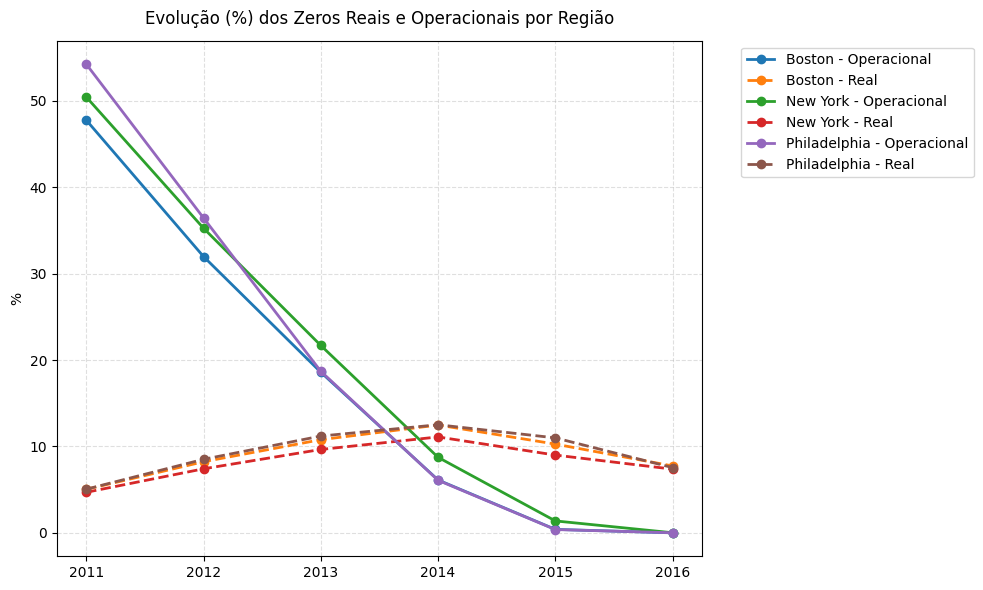

In [ ]:
plt.figure(figsize=(10,6))

for reg in df["region"].unique():
    subset = df[df["region"] == reg]

    total_year = subset.groupby("year").size()
    zeros_year = subset.groupby("year")[["zero_operacional","zero_real"]].sum()

    pct = (zeros_year.div(total_year, axis=0) * 100).round(2)

    plt.plot(pct.index, pct["zero_operacional"], marker="o", linewidth=2, label=f"{reg} - Operacional")
    plt.plot(pct.index, pct["zero_real"], marker="o", linewidth=2, linestyle="--", label=f"{reg} - Real")

plt.title("Evolução (%) dos Zeros Reais e Operacionais por Região", pad=12)
plt.ylabel("%")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


A análise exploratória demonstrou que os anos de 2011 e 2012 apresentam um volume excepcionalmente elevado de registros incompletos e inconsistentes, especialmente em combinações onde sales = 0 e mean_price é ausente (“NaN & Zero”). Esses registros caracterizam zeros operacionais, ligados a falhas de implantação, ausência de cadastro de itens, inconsistência na integração das lojas ou problemas na captura de dados. Em 2011, mais de 50% das observações possuíam mean_price ausente, e mais de 55% tinham vendas iguais a zero; em 2012, esses percentuais permaneciam elevados, evidenciando instabilidade relevante na operação.

Um aspecto fundamental identificado na análise é que esse padrão não ocorre apenas em alguns produtos ou unidades específicas, mas sim de forma generalizada em todas as regiões, categorias, lojas e itens da base. Os heatmaps e gráficos empilhados mostram que o comportamento se repete em Boston, New York e Philadelphia, e está presente de maneira uniforme nas dez lojas e nas três categorias de produtos. Essa homogeneidade demonstra que os problemas observados não refletem baixa demanda para itens específicos, mas sim um fenômeno sistêmico de implantação, indicando ausência de operação efetiva, cadastro incompleto ou falhas estruturais do sistema no período inicial.

A partir de 2013, verifica-se uma mudança estrutural clara: a proporção de valores ausentes e zeros operacionais cai drasticamente, enquanto aumenta substancialmente o volume de registros classificados como Normais (vendas e preços válidos). Os zeros reais — casos com preço válido e vendas zero — tornam-se mais frequentes e passam a refletir fenômenos comerciais legítimos, como sazonalidade, baixa procura, substituição de produtos ou ciclo de vida do item. Esse comportamento confirma que o sistema se estabiliza totalmente a partir de 2013, e que os dados passam a representar operações de varejo reais, e não limitações tecnológicas.

Manter 2011 e 2012 no treinamento induziria o modelo a aprender relações equivocadas, como a falsa associação entre ausência de preço e ausência de vendas, prejudicando a acurácia e comprometendo a capacidade de generalização. A literatura de previsão de demanda e as práticas do varejo reforçam que períodos de implantação devem ser excluídos, pois introduzem ruído e distorcem padrões temporais.

Dessa forma, a exclusão dos anos de 2011 e 2012 é técnica e estatisticamente justificada, pois esses anos não refletem comportamento real do mercado e apresentam inconsistências sistêmicas que afetam todas as lojas e itens. Trabalhar apenas com o período de 2013 a 2016 garante que a modelagem seja realizada sobre dados estáveis, consistentes e representativos do comportamento verdadeiro de vendas da rede.

**3. PROCESSAMENTO DOS DADOS**

In [ ]:
import pandas as pd
import numpy as np

# ===========================================================
# 1. Filtrar anos válidos (>= 2013)
# ===========================================================
df["year_month"] = pd.to_datetime(df["year_month"], errors="coerce").dt.to_period("M")
df["year"] = df["year_month"].dt.year

df = df[df["year"] >= 2013].copy()
df.reset_index(drop=True, inplace=True)


# ===========================================================
# 2. Converter tipos e padronizar texto
# ===========================================================
cat_cols = ["item", "category", "department", "store_code", "region"]

for col in cat_cols:
    df[col] = df[col].astype(str).str.strip()

df["sales"] = pd.to_numeric(df["sales"], errors="coerce")
df["mean_price"] = pd.to_numeric(df["mean_price"], errors="coerce")


# ===========================================================
# 3. Remover colunas desnecessárias
# ===========================================================
cols_to_drop = [col for col in ["id", "store"] if col in df.columns]
df = df.drop(columns=cols_to_drop)


# ===========================================================
# 4. Tratar valores impossíveis
# ===========================================================
df.loc[df["sales"] < 0, "sales"] = np.nan
df.loc[df["mean_price"] <= 0, "mean_price"] = np.nan  # preço nunca é <= 0


# ===========================================================
# 5. Remover itens com mean_price totalmente NaN
# ===========================================================
# Identificar itens inválidos
items_completamente_nan = (df.groupby("item")["mean_price"]
    .apply(lambda x: x.isna().all()))

items_invalidos = items_completamente_nan[items_completamente_nan].index.tolist()

print("Itens removidos por não possuírem nenhum preço válido:")
print(items_invalidos)

# Remover do dataframe esses itens por completo
df = df[~df["item"].isin(items_invalidos)].copy()


# ===========================================================
# 6. Imputar mean_price apenas para itens parcialmente válidos
# ===========================================================
df["mean_price"] = df.groupby("item")["mean_price"].transform(
    lambda x: x.fillna(x.median()))

#Cada item é tratado isoladamente

#Dentro de cada item, os NaN são preenchidos apenas com a mediana daquele item

# mediana não é influenciada por outros itens

#A imputação é feita apenas para os itens que tinham valores válidos


# ===========================================================
# 7. Criar flag de zeros reais
# ===========================================================
df["zero_real"] = ((df["sales"] == 0) & (df["mean_price"] > 0)).astype(int)


# ===========================================================
# 8. Remover duplicatas e finalizar
# ===========================================================
df = df.drop_duplicates().reset_index(drop=True)

print("\nShape final:", df.shape)
print("Colunas finais:")
print(df.dtypes)

df.head()


Itens removidos por não possuírem nenhum preço válido:
[]

Shape final: (1219600, 12)
Colunas finais:
year_month          period[M]
item                   object
category               object
department             object
store_code             object
region                 object
sales                 float64
mean_price            float64
year                    int64
zero_type              object
zero_operacional        int64
zero_real               int64
dtype: object


,year_month,item,category,department,store_code,region,sales,mean_price,year,zero_type,zero_operacional,zero_real
0,2013-01,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,Boston,0.0,10.9858,2013,zero_operacional,1,1
1,2013-01,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_2,Boston,0.0,10.9858,2013,zero_operacional,1,1
2,2013-01,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_3,Boston,0.0,10.9858,2013,zero_operacional,1,1
3,2013-01,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,0.0,10.9858,2013,zero_operacional,1,1
4,2013-01,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_2,New York,0.0,10.9858,2013,zero_operacional,1,1


In [ ]:
# Remover colunas que vieram apenas da EDA (não podem ir para modelagem) e aquelas que não contribuem de forma significativa
cols_remove = ["zero_type", "zero_operacional", "zero_real"]

df = df.drop(columns=[c for c in cols_remove if c in df.columns])
print("Colunas removidas com sucesso:", cols_remove)


Colunas removidas com sucesso: ['zero_type', 'zero_operacional', 'zero_real']


===== ESTATÍSTICAS DESCRITIVAS (Sales e Mean Price) =====



,count,mean,std,min,25%,50%,75%,max
sales,1219600.0,36.714486,95.054176,0.00,3.0000,13.0,35.000,10821.0000
mean_price,1219600.0,5.585785,4.558529,0.12,2.6201,4.2,7.176,74.8625


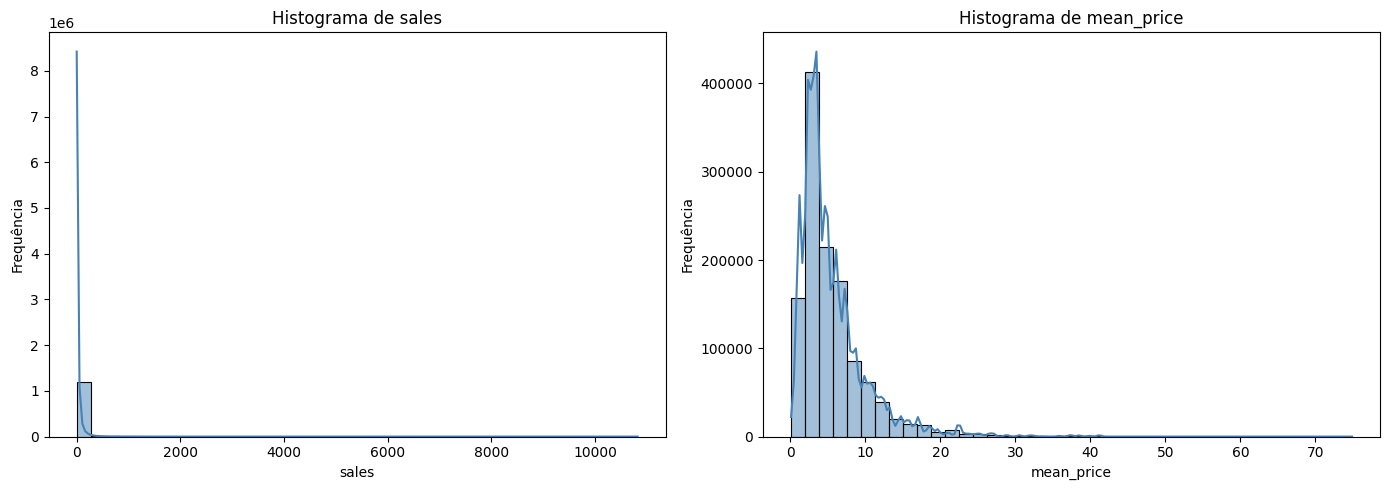

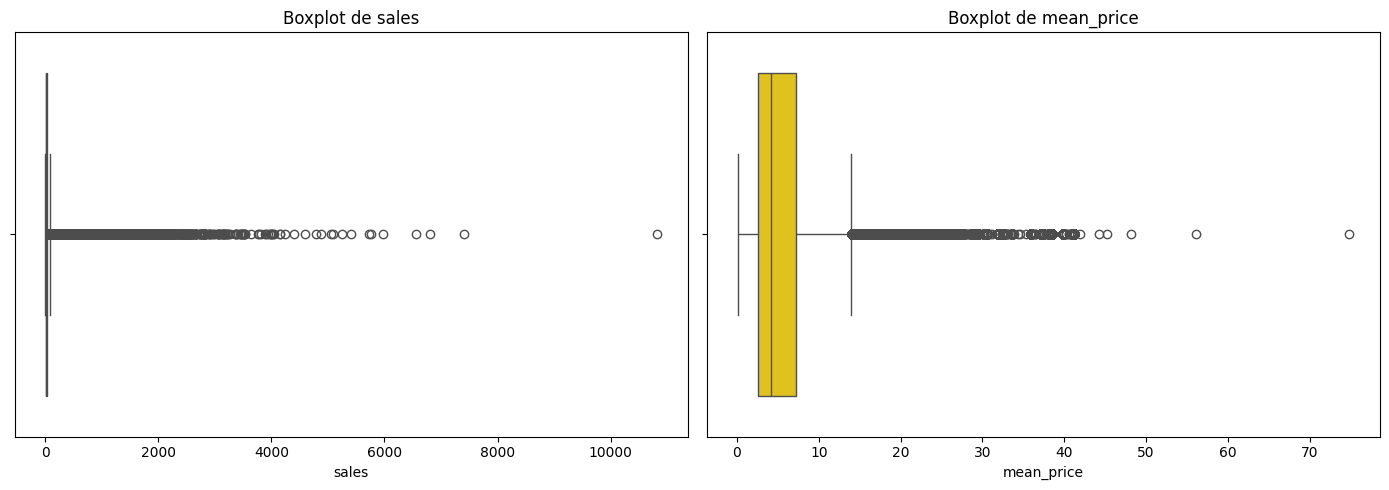

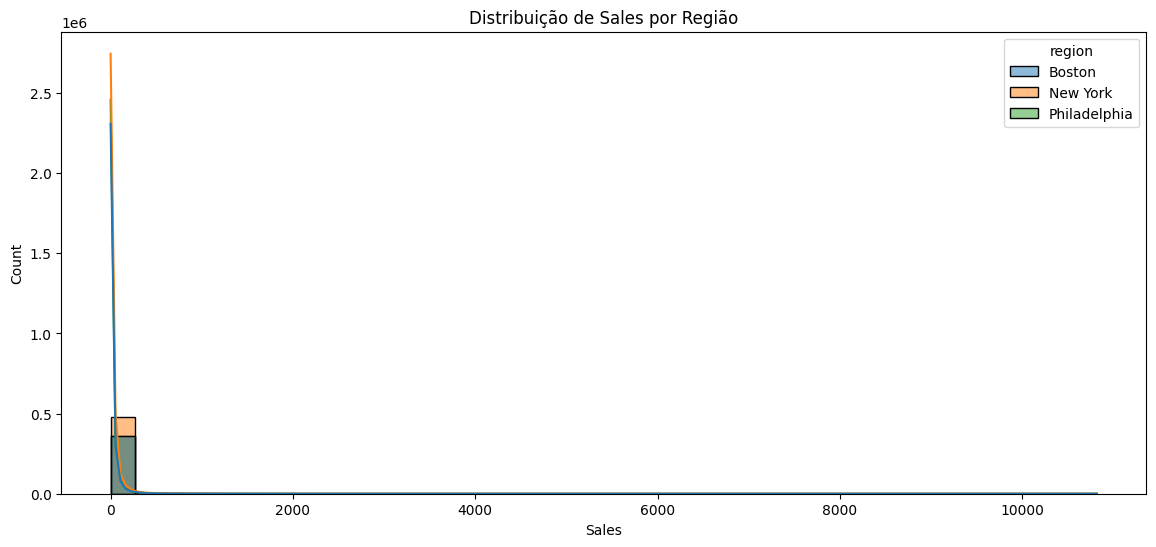

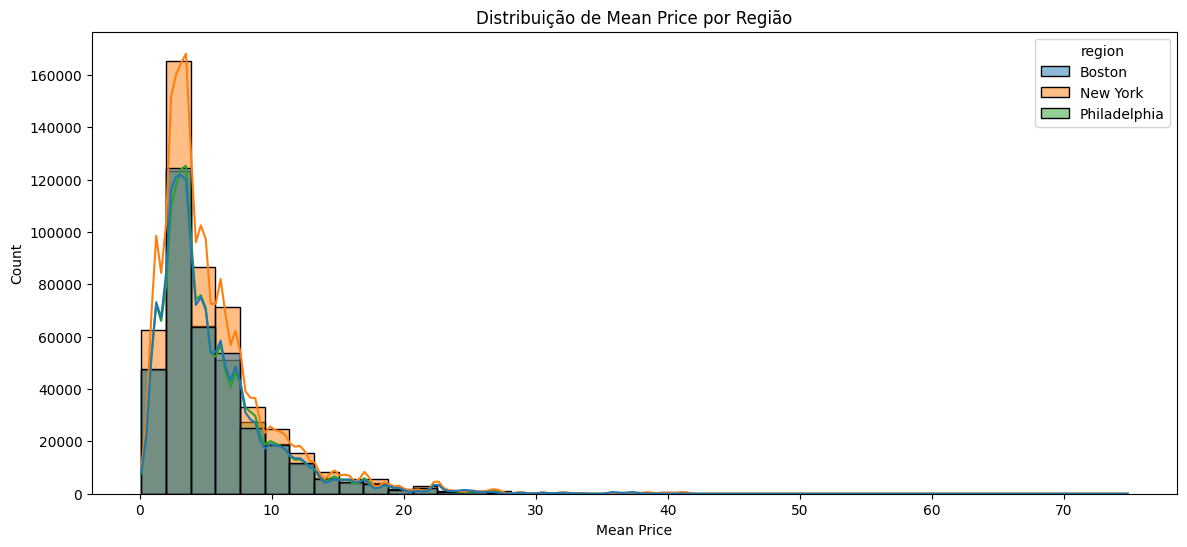

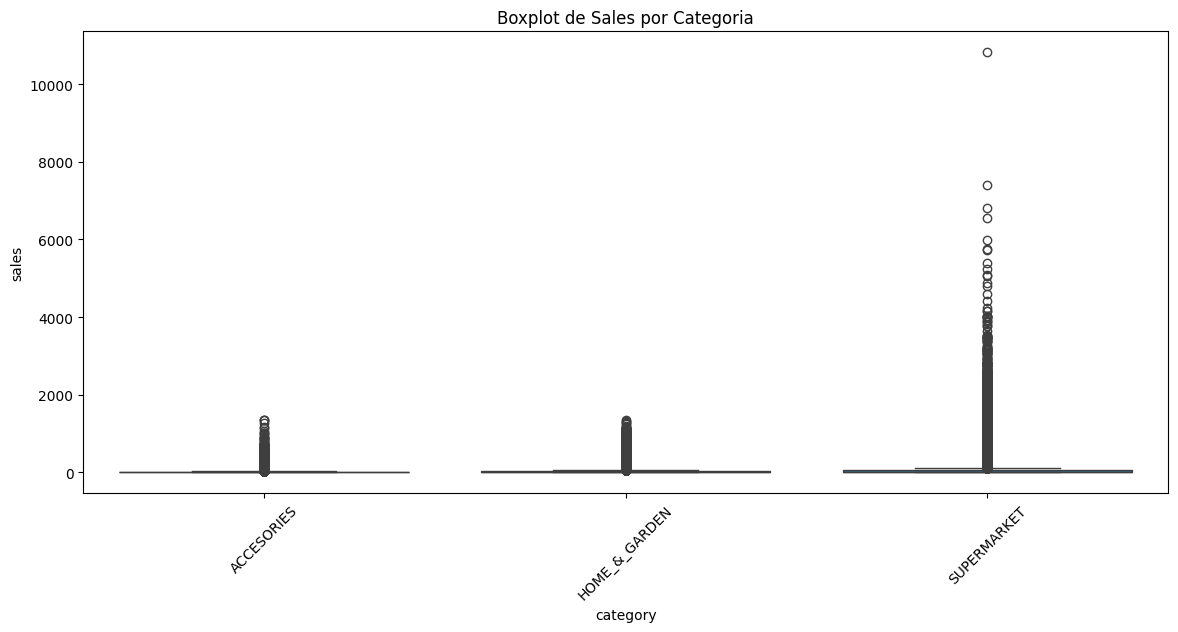

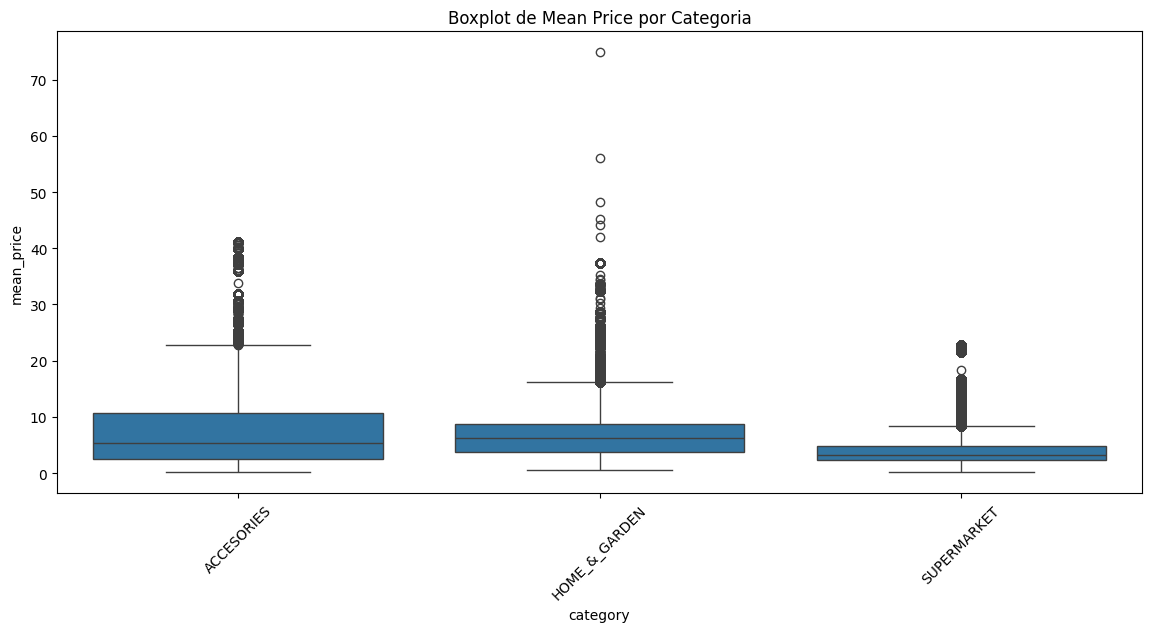

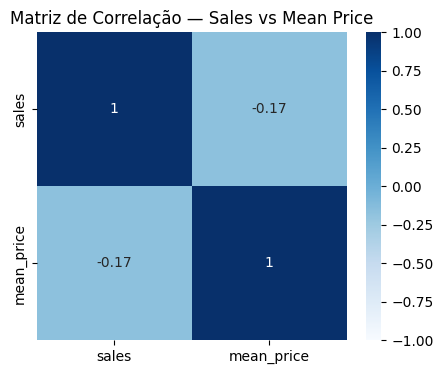

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===========================================================
# 0. Estatística descritiva somente das variáveis numéricas
# ===========================================================

num_cols = ["sales", "mean_price"]

print("===== ESTATÍSTICAS DESCRITIVAS (Sales e Mean Price) =====\n")
display(df[num_cols].describe().T)


# ===========================================================
# 1. HISTOGRAMAS DAS VARIÁVEIS NUMÉRICAS
# ===========================================================

plt.figure(figsize=(14,5))

for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 2, i)
    sns.histplot(df[col], kde=True, bins=40, color="steelblue")
    plt.title(f"Histograma de {col}")
    plt.xlabel(col)
    plt.ylabel("Frequência")

plt.tight_layout()
plt.show()


# ===========================================================
# 2. BOXPLOTS DAS VARIÁVEIS NUMÉRICAS
# ===========================================================

plt.figure(figsize=(14,5))

for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=df[col], color="gold")
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)

plt.tight_layout()
plt.show()


# ===========================================================
# 3. HISTOGRAMAS POR REGIÃO
# ===========================================================

plt.figure(figsize=(14,6))
sns.histplot(data=df, x="sales", hue="region", kde=True, bins=40)
plt.title("Distribuição de Sales por Região")
plt.xlabel("Sales")
plt.show()

plt.figure(figsize=(14,6))
sns.histplot(data=df, x="mean_price", hue="region", kde=True, bins=40)
plt.title("Distribuição de Mean Price por Região")
plt.xlabel("Mean Price")
plt.show()


# ===========================================================
# 4. BOXPLOTS POR CATEGORIA
# ===========================================================

plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="category", y="sales")
plt.title("Boxplot de Sales por Categoria")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="category", y="mean_price")
plt.title("Boxplot de Mean Price por Categoria")
plt.xticks(rotation=45)
plt.show()


# ===========================================================
# 5. MATRIZ DE CORRELAÇÃO (somente variáveis numéricas)
# ===========================================================

plt.figure(figsize=(5,4))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="Blues", vmin=-1, vmax=1)
plt.title("Matriz de Correlação — Sales vs Mean Price")
plt.show()


In [ ]:
df.to_parquet("df_processado.parquet", index=False)
df.to_csv("df_processado.csv", index=False)
print("Arquivo salvo como df_processado.parquet")
print("Arquivo salvo como df_processado.csv")


Arquivo salvo como df_processado.parquet
Arquivo salvo como df_processado.csv


A análise exploratória dos dados permitiu compreender com precisão o comportamento das variáveis que compõem o conjunto e revelou padrões estruturais fundamentais para o desenvolvimento do modelo de previsão de vendas. Após a limpeza inicial e a remoção dos anos operacionalmente problemáticos (2011 e 2012), observou-se que a base passou a apresentar consistência temporal, coerência entre categorias e equilíbrio entre regiões.

Os gráficos de distribuição e as estatísticas descritivas evidenciaram que a variável sales possui forte assimetria positiva, fenômeno típico em ambientes de varejo, nos quais a maior parte dos produtos apresenta baixo volume de vendas enquanto poucos itens registram picos mais elevados. Esse comportamento natural foi reforçado pela presença de zeros reais (vendas iguais a zero com preço válido), que representam períodos de baixa demanda e carregam informação importante para modelagem.

A análise do preço médio (mean_price) demonstrou que os itens apresentam faixas de valores distintas entre categorias, caracterizando distribuições multimodais. A imputação pela mediana dentro de cada item preservou essas estruturas, permitindo que as análises fossem realizadas sobre dados consistentes e alinhados ao comportamento real dos produtos.

A análise exploratória identificou a presença de valores extremos nas variáveis de vendas, caracterizados como outliers estatísticos nos boxplots. No entanto, esses valores foram mantidos no dataset, pois representam fenômenos reais e naturais do ambiente de varejo, como sazonalidade, promoções e flutuações normais da demanda.


Os heatmaps temporais confirmaram que os zeros operacionais — vendas iguais a zero acompanhadas de mean_price ausente — concentravam-se exclusivamente nos anos de 2011 e 2012, reforçando a decisão metodológica de excluí-los completamente. Após 2013, o comportamento das séries se estabiliza e os zeros passam a refletir fenômenos reais de demanda, não falhas de registro, garantindo confiabilidade à base utilizada para modelagem.

A comparação entre regiões indicou que Boston, New York e Philadelphia apresentam padrões estatísticos muito semelhantes, tanto nas distribuições de vendas quanto de preços. Essa uniformidade demonstra que o dataset é estruturalmente equilibrado e não requer tratamentos específicos por região. Da mesma forma, as análises por categoria revelaram padrões distintos entre grupos de produtos, justificando a futura aplicação de técnicas de clusterização para segmentar comportamentos antes da previsão de vendas.

Por fim, a matriz de correlação revelou relação fraca entre sales e mean_price, indicando que o preço médio, isoladamente, não determina o volume de vendas. Esse achado reforça a necessidade de criação de features adicionais e da incorporação de variáveis temporais, categóricas e derivadas no modelo preditivo.

De forma geral, a EDA demonstrou que, após o tratamento adequado, o dataset é robusto, coerente, representativo e apto para as etapas de agrupamento e modelagem preditiva, estabelecendo um sólido alicerce para o restante do projeto.